# Information about data

- `Image` and `Variants` column, if my understanding is correct, have the identical image. The `Image` column has an actual image while the `Variants` has the link to the Amazon site for that specific product. A lot of those products are not on Amazon anymore so the link leads to an error.

In [2]:
import pandas as pd
from IPython.display import display

In [3]:
df = pd.read_csv('data.csv')

In [8]:
print("="*60)
print("Entire dataset:")
print("="*60)
display(df.head(5))

print("="*60)
print("Dataset shape:")
print("="*60)
print(df.shape)


print("\n")
print("="*60)
print("Columns in the dataset:")
print("="*60)
print(df.columns.tolist())

print("\n")
print("="*60)
print("Column types:")
print("="*60)
print(df.dtypes)

print("\n")
print("="*60)
print("NaN counts:")
print("="*60)
print(df.isna().sum())

print("\n")
print("="*60)
print("Columns where all values are NaN:")
print("="*60)
print("The columns that should be removed because all values are NaN are:")
for col in df.columns:
    if df[col].isna().sum() == df.shape[0]:
        print(f"  {col}")


print("\n")
print("="*60)
print("Columns we can work with")
print("="*60)

for col in df.columns:
    if df[col].isna().sum() != df.shape[0]:
        print(f"  {col}")
valid_cols = [col for col in df.columns if df[col].isna().sum() != df.shape[0]]
display(df[valid_cols].head(3))



Entire dataset:


,Uniq Id,Product Name,Brand Name,Asin,Category,Upc Ean Code,List Price,Selling Price,Quantity,Model Number,...,Product Url,Stock,Product Details,Dimensions,Color,Ingredients,Direction To Use,Is Amazon Seller,Size Quantity Variant,Product Description
0,4c69b61db1fc16e7013b43fc926e502d,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",NaN,NaN,Sports & Outdoors | Outdoor Recreation | Skate...,NaN,NaN,$237.68,NaN,NaN,...,https://www.amazon.com/DB-Longboards-CoreFlex-...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
1,66d49bbed043f5be260fa9f7fbff5957,"Electronic Snap Circuits Mini Kits Classpack, ...",NaN,NaN,Toys & Games | Learning & Education | Science ...,NaN,NaN,$99.95,NaN,55324,...,https://www.amazon.com/Electronic-Circuits-Cla...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
2,2c55cae269aebf53838484b0d7dd931a,3Doodler Create Flexy 3D Printing Filament Ref...,NaN,NaN,Toys & Games | Arts & Crafts | Craft Kits,NaN,NaN,$34.99,NaN,NaN,...,https://www.amazon.com/3Doodler-Plastic-Innova...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
3,18018b6bc416dab347b1b7db79994afa,Guillow Airplane Design Studio with Travel Cas...,NaN,NaN,Toys & Games | Hobbies | Models & Model Kits |...,NaN,NaN,$28.91,NaN,142,...,https://www.amazon.com/Guillow-Airplane-Design...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
4,e04b990e95bf73bbe6a3fa09785d7cd0,Woodstock- Collage 500 pc Puzzle,NaN,NaN,Toys & Games | Puzzles | Jigsaw Puzzles,NaN,NaN,$17.49,NaN,62151,...,https://www.amazon.com/Woodstock-Collage-500-p...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN


Dataset shape:
(10002, 28)


Columns in the dataset:
['Uniq Id', 'Product Name', 'Brand Name', 'Asin', 'Category', 'Upc Ean Code', 'List Price', 'Selling Price', 'Quantity', 'Model Number', 'About Product', 'Product Specification', 'Technical Details', 'Shipping Weight', 'Product Dimensions', 'Image', 'Variants', 'Sku', 'Product Url', 'Stock', 'Product Details', 'Dimensions', 'Color', 'Ingredients', 'Direction To Use', 'Is Amazon Seller', 'Size Quantity Variant', 'Product Description']


Column types:
Uniq Id                   object
Product Name              object
Brand Name               float64
Asin                     float64
Category                  object
Upc Ean Code              object
List Price               float64
Selling Price             object
Quantity                 float64
Model Number              object
About Product             object
Product Specification     object
Technical Details         object
Shipping Weight           object
Product Dimensions        objec

,Uniq Id,Product Name,Category,Upc Ean Code,Selling Price,Model Number,About Product,Product Specification,Technical Details,Shipping Weight,Product Dimensions,Image,Variants,Product Url,Is Amazon Seller
0,4c69b61db1fc16e7013b43fc926e502d,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",Sports & Outdoors | Outdoor Recreation | Skate...,NaN,$237.68,NaN,Make sure this fits by entering your model num...,Shipping Weight: 10.7 pounds (View shipping ra...,NaN,10.7 pounds,NaN,https://images-na.ssl-images-amazon.com/images...,https://www.amazon.com/DB-Longboards-CoreFlex-...,https://www.amazon.com/DB-Longboards-CoreFlex-...,Y
1,66d49bbed043f5be260fa9f7fbff5957,"Electronic Snap Circuits Mini Kits Classpack, ...",Toys & Games | Learning & Education | Science ...,NaN,$99.95,55324,Make sure this fits by entering your model num...,Product Dimensions: 14.7 x 11.1 x 10.2...,The snap circuits mini kits classpack provides...,4 pounds,14.7 x 11.1 x 10.2 inches 4.06 pounds,https://images-na.ssl-images-amazon.com/images...,NaN,https://www.amazon.com/Electronic-Circuits-Cla...,Y
2,2c55cae269aebf53838484b0d7dd931a,3Doodler Create Flexy 3D Printing Filament Ref...,Toys & Games | Arts & Crafts | Craft Kits,NaN,$34.99,NaN,Make sure this fits by entering your model num...,ProductDimensions:10.3x3.4x0.8inches|ItemWeigh...,show up to 2 reviews by default No longer are ...,12.8 ounces,NaN,https://images-na.ssl-images-amazon.com/images...,NaN,https://www.amazon.com/3Doodler-Plastic-Innova...,Y


# images

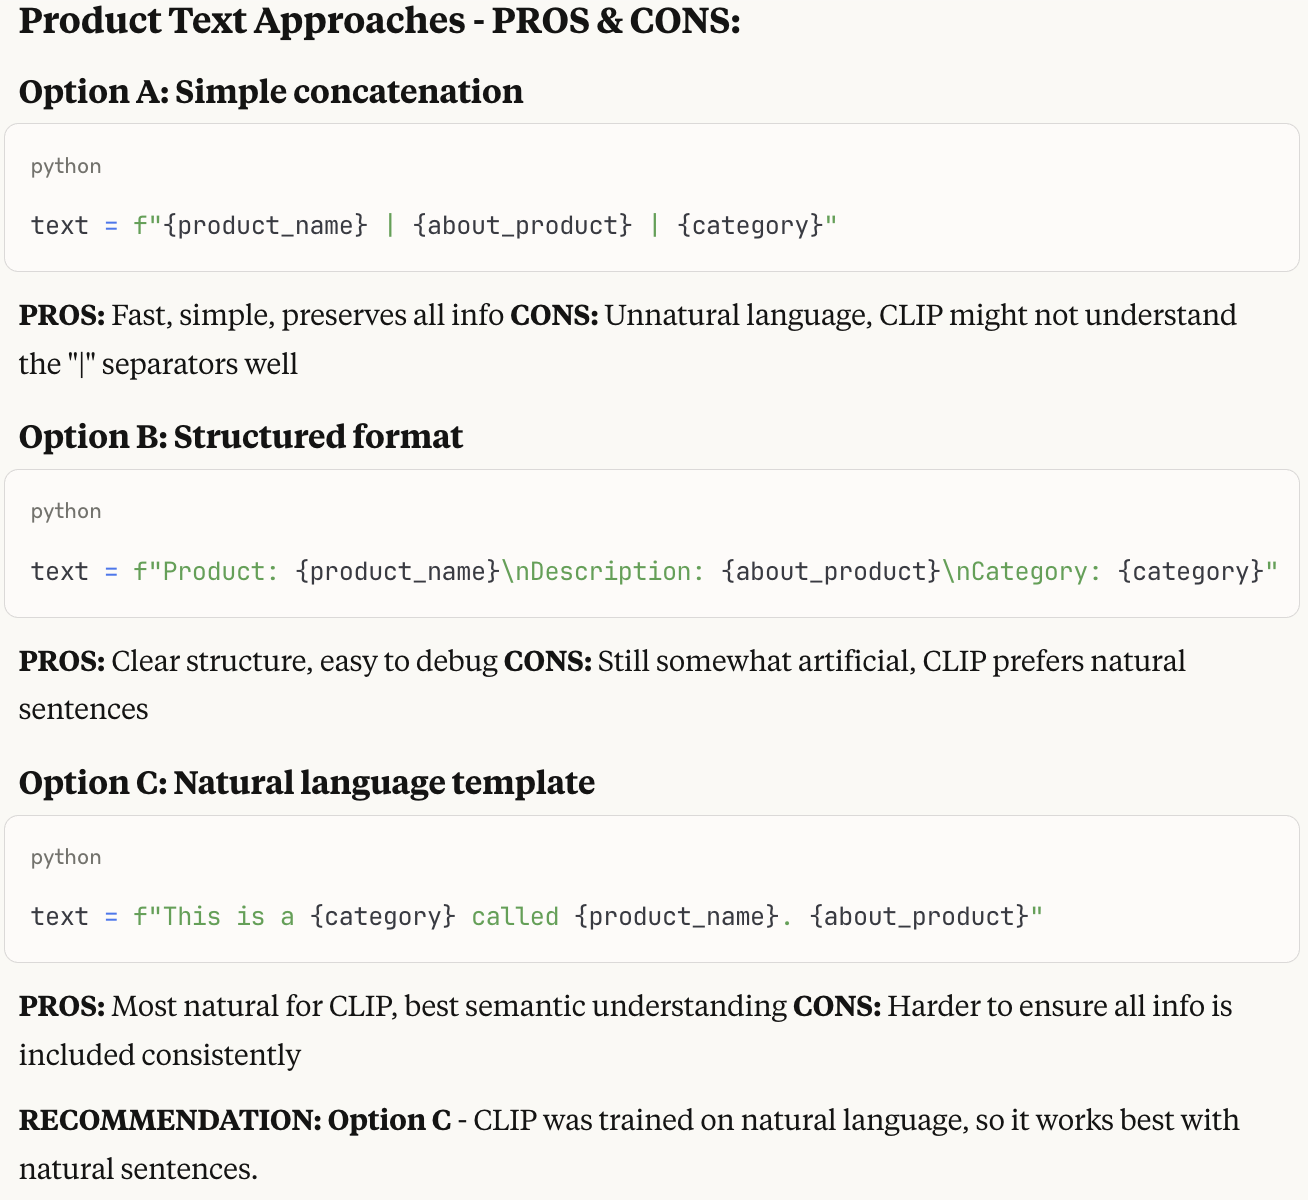
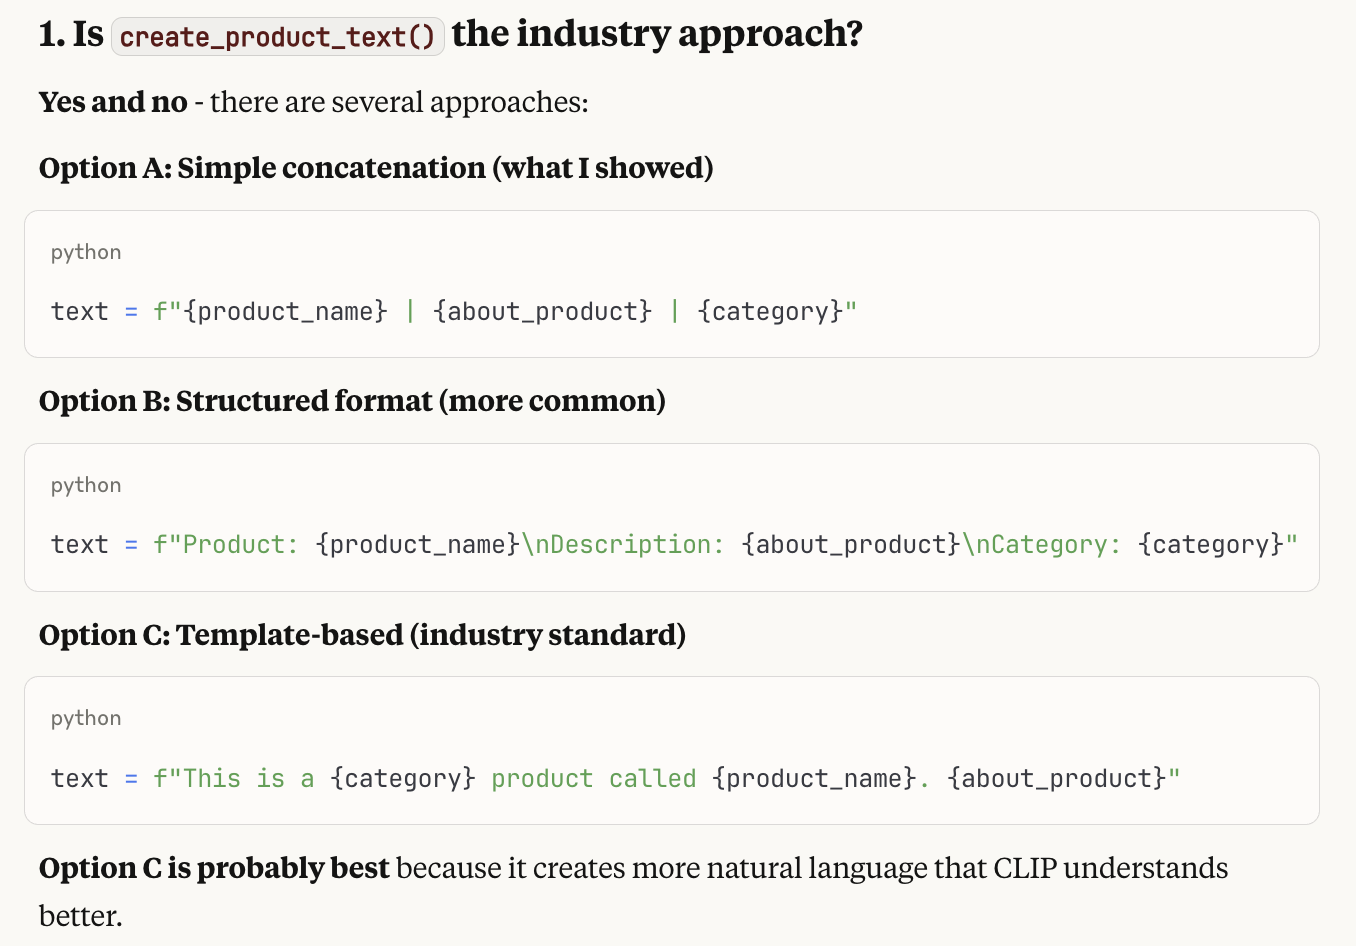

# code

text_columns = [
    'Product Name',
    'Category',
    'Selling Price',
    'Model Number',
    'About Product',
    'Technical Details',
    'Shipping Weight',
    'Product Dimensions',
    'Is Amazon Seller',
    'product url'
]

image_columns = [
    'image'  
]

In [9]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np

In [ ]:
# load clip
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# text embeddings
def get_text_embedding(text):
    inputs = processor(text=[text], return_tensors="pt", padding=True)
    with torch.no_grad():
        embedding = model.get_text_features(**inputs)
    return embedding.numpy()[0]

# image embeddings
def get_image_embedding(image):
    inputs = processor(images=[image], return_tensors="pt", padding=True)
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
    return embedding.numpy()[0]

In [ ]:
# Test text
text_emb = get_text_embedding("Samsung Galaxy phone")
print(f"Text embedding shape: {text_emb.shape}")

# Test image (dummy)
dummy_img = Image.new('RGB', (224, 224), color='red')
img_emb = get_image_embedding(dummy_img)  
print(f"Image embedding shape: {img_emb.shape}")

# Test similarity
similarity = np.dot(text_emb, img_emb) / (np.linalg.norm(text_emb) * np.linalg.norm(img_emb))
print(f"Text-image similarity: {similarity:.3f}")
